In [2]:
from pathlib import Path
import numpy as np

# Project root (GNN-for-Grain-Track)
PROJECT_ROOT = Path.cwd().parent

Functions to read data from for_ML_quaternion_perMatpoint_pergrain.txt files

In [3]:
from pathlib import Path
import numpy as np
import re

def _read_bracket_array(lines, start_idx):
    """
    Reads one numpy-style bracket array that may span multiple lines.
    Returns (array, next_idx).
    """
    s = lines[start_idx].strip()
    if not s.startswith("["):
        raise ValueError(f"Expected '[' at line {start_idx}: {s[:80]}")

    # Accumulate until we see a closing bracket
    while not s.strip().endswith("]"):
        start_idx += 1
        if start_idx >= len(lines):
            raise ValueError("Unexpected EOF while reading a bracket array.")
        s += " " + lines[start_idx].strip()

    # Now s is like: "[ ... ]"
    content = s.strip()[1:-1]
    arr = np.fromstring(content, sep=" ")
    return arr, start_idx + 1


def read_increment_component_arrays_multiline(path: Path):
    with open(path, "r") as f:
        raw_lines = [ln.rstrip("\n") for ln in f if ln.strip()]

    # find first increment line
    inc_start = next((i for i, ln in enumerate(raw_lines) if ln.strip().startswith("increment_")), None)
    if inc_start is None:
        raise ValueError("No 'increment_' blocks found.")

    # header -> component names (exclude 'inc')
    header = [h.strip() for h in raw_lines[:inc_start]]
    components = [h for h in header if h != "inc"]
    n_comp = len(components)
    if n_comp == 0:
        raise ValueError("No components found in header.")

    incs = []
    blocks = []

    i = inc_start
    while i < len(raw_lines):
        ln = raw_lines[i].strip()
        if not ln.startswith("increment_"):
            i += 1
            continue

        m = re.match(r"increment_(\d+)", ln)
        if not m:
            raise ValueError(f"Bad increment line: {ln}")
        inc = int(m.group(1))
        i += 1  # move to first array after increment line

        block = []
        for _ in range(n_comp):
            arr, i = _read_bracket_array(raw_lines, i)  # i advances past the array
            block.append(arr)

        block = np.vstack(block)  # (n_comp, n_matpoints)
        incs.append(inc)
        blocks.append(block)

    incs = np.array(incs, dtype=int)
    arr = np.stack(blocks, axis=0)  # (n_increments, n_comp, n_matpoints)
    return components, incs, arr


Functions for calculating mean quaternion

In [4]:
def normalize_quat(q, axis=-1, eps=1e-12):
    q = np.asarray(q, dtype=float)
    n = np.linalg.norm(q, axis=axis, keepdims=True)
    return q / np.maximum(n, eps)

def misorientation_to_mean_single(Q_mp, q_mean):
    """
    Q_mp: (n_mp, 4)  material-point quaternions (not necessarily normalized)
    q_mean: (4,)     mean quaternion (not necessarily normalized)

    Returns
    -------
    theta: (n_mp,) in radians, sign-safe via abs(dot)
    """
    Qn = normalize_quat(Q_mp, axis=1)         # (n_mp,4)
    qm = normalize_quat(q_mean, axis=0).ravel()  # (4,)
    dot = np.abs(Qn @ qm)                    # (n_mp,)
    dot = np.clip(dot, -1.0, 1.0)
    return 2.0 * np.arccos(dot)

def mean_quaternion_over_matpoints_sum(Q, max_iter=10, tol=1e-10):
    """
    Q: (n_increments, 4, n_matpoints)
    returns q_mean: (n_increments, 4)
    """
    n_inc = Q.shape[0]
    q_mean = np.zeros((n_inc, 4), dtype=float)

    for t in range(n_inc):
        Q_mp = normalize_quat(Q[t].T, axis=-1)  # (n_mp,4)
        # q_ref = Q_mp[0].copy()
        q_ref = np.array([1.0, 0.0, 0.0, 0.0])  # identity

        q_old = None
        for _ in range(max_iter):
            # Compute dot products q^k · q_ref. If dot < 0, flip q^k -> -q^k.
            dots = Q_mp @ q_ref
            Q_aligned = Q_mp.copy()
            Q_aligned[dots < 0] *= -1.0     # enforce consistent sign

            s = Q_aligned.sum(axis=0)       # ∑_k q^k
            q_new = s / np.linalg.norm(s)   # enforce ||q^M||=1

            # compare q_new to q_old, but because q and -q represent the same rotation,
            # we check both distances and take the smaller.
            if q_old is not None:
                if min(np.linalg.norm(q_new - q_old), np.linalg.norm(q_new + q_old)) < tol:
                    break
            
            # theta_deg = np.degrees(misorientation_to_mean_single(Q_mp, q_new))
            # print("mean(deg) =", theta_deg.mean(), "max(deg) =", theta_deg.max())

            # Update for next iteration: using the current mean as the new reference
            q_old = q_new
            q_ref = q_new

        q_mean[t] = q_new   # store mean quaternion for increment t

        # keep consistent sign across increments
        if t > 0 and np.dot(q_mean[t], q_mean[t-1]) < 0:
            q_mean[t] *= -1.0

    # print(t)
    return q_mean

Plot comparison with mean quaternion with material point quaternions

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_quats_increment(Q, qM, inc=0, align_to='mean', show_mean=True, figsize=(10, 6)):
    """
    Plot quaternion components for all material points at a chosen increment,
    with optional sign alignment to avoid misleading flips.

    Parameters
    ----------
    Q : array, shape (n_inc, 4, n_mp)
    qM : array, shape (n_inc, 4)
    inc : int
        Increment index to plot.
    align_to : {'mean', 'first', None}
        - 'mean': flip each q_i so dot(q_i, q_mean) >= 0  (recommended)
        - 'first': flip each q_i so dot(q_i, q_first_mp) >= 0
        - None: no alignment (not recommended if sign flips exist)
    show_mean : bool
        Plot mean quaternion as a horizontal line for each component.
    """
    Q_inc = normalize_quat(Q[inc].T, axis=1)   # (n_mp, 4)
    q_mean = normalize_quat(qM[inc], axis=0).reshape(4,)  # (4,)

    if align_to == 'mean':
        ref = q_mean
    elif align_to == 'first':
        ref = Q_inc[0]
    elif align_to is None:
        ref = None
    else:
        raise ValueError("align_to must be one of {'mean','first',None}")

    if ref is not None:
        dots = Q_inc @ ref
        Q_plot = Q_inc.copy()
        Q_plot[dots < 0] *= -1.0
        # also align mean to the same hemisphere as ref for visual consistency
        if np.dot(q_mean, ref) < 0:
            q_mean = -q_mean
    else:
        Q_plot = Q_inc

    mp = np.arange(Q_plot.shape[0])
    labels = ['w', 'x', 'y', 'z']

    plt.figure(figsize=figsize)
    for k in range(4):
        plt.plot(mp, Q_plot[:, k], marker='o', linewidth=1, label=f'mp {labels[k]}')

        if show_mean:
            plt.axhline(q_mean[k], linewidth=1)

    plt.xlabel("Material point index")
    plt.ylabel("Quaternion component value")
    plt.title(f"Increment {inc}: material-point quaternions (aligned_to={align_to})")
    plt.grid(True, alpha=0.3)
    plt.legend(ncols=2, fontsize=9)
    plt.tight_layout()
    plt.show()


def plot_misorientation_increment(Q, qM, inc=0, degrees=True, figsize=(10, 4)):
    """
    Plot misorientation angle between each material point quaternion and mean at chosen increment.
    Sign-safe because it uses abs(dot).
    """
    Q_inc = normalize_quat(Q[inc].T, axis=1)          # (n_mp, 4)
    q_mean = normalize_quat(qM[inc], axis=0).reshape(4,)

    dot = np.abs(Q_inc @ q_mean)
    dot = np.clip(dot, -1.0, 1.0)
    theta = 2.0 * np.arccos(dot)

    if degrees:
        theta = np.degrees(theta)
        ylab = "Misorientation (deg)"
    else:
        ylab = "Misorientation (rad)"

    plt.figure(figsize=figsize)
    plt.plot(np.arange(len(theta)), theta, marker='o')
    plt.xlabel("Material point index")
    plt.ylabel(ylab)
    plt.title(f"Increment {inc}: misorientation to mean")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Plot comparison between avg and material point quaternions for a chosen loadcase and grain_index

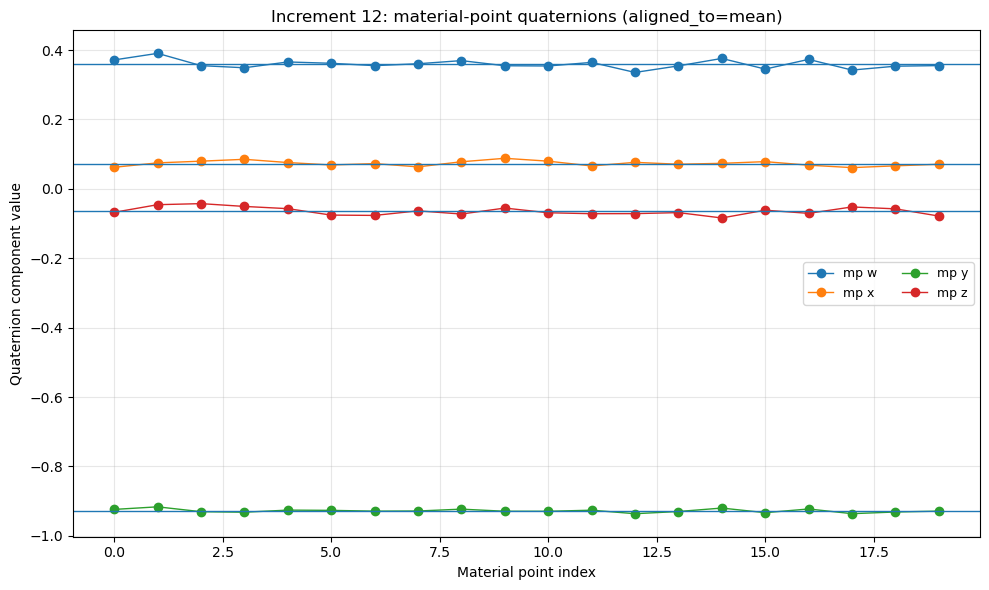

In [6]:
type = "Compression"
# type = "Traction"
direction = "X"
# direction = "XZ"
# direction = "Z"
grain_index = 21

measurement = "for_ML_quaternion_perMatpoint_pergrain"
loadcase = f"{type}{direction}"
filename = (
    PROJECT_ROOT
    / "2D_10%strain_100grains"
    / "results_grain_matpoint"
    / loadcase
    / measurement
    / f"grain_{grain_index}.txt"
)

components, incs, Q = read_increment_component_arrays_multiline(filename)

qM = mean_quaternion_over_matpoints_sum(Q, max_iter=30)

# for i in range(len(Q)):
#     print(f'\nIncrement {i*10}')
#     print(f'Avg orientation: \n{qM[i]}')
#     print(f'Original material points: \n{Q[i]}')

increment = 12
plot_quats_increment(Q, qM, increment)

Create .txt files for quaternion averages

In [ ]:
from pathlib import Path
import numpy as np

# type = "Compression"
type = "Traction"
direction = "X"
measurement = "for_ML_quaternion_perMatpoint_pergrain"

loadcase = f"{type}{direction}"

input_root = (
    PROJECT_ROOT
    / "2D_10%strain_100grains"
    / "results_grain_matpoint"
    / loadcase
    / measurement
)

output_root = (
    PROJECT_ROOT
    / "2D_10%strain_100grains"
    / "results_grain_matpoint"
    / loadcase
    / "for_ML_quaternion_average"
)

output_root.mkdir(parents=True, exist_ok=True)

for grain_index in range(100):
    infile = input_root / f"grain_{grain_index}.txt"

    if not infile.exists():
        print(f"Skipping grain {grain_index}: file not found")
        continue

    # read data
    components, incs, Q = read_increment_component_arrays_multiline(infile)

    # compute mean quaternion per increment
    qM = mean_quaternion_over_matpoints_sum(Q, max_iter=30)
    # qM shape: (n_inc, 4)

    # output file
    outfile = output_root / f"grain_{grain_index}_avg_quaternion.txt"

    with open(outfile, "w") as f:
        f.write("# inc   q0   q1   q2   q3\n")
        for i, inc in enumerate(incs):
            f.write(
                f"{inc:6d} "
                f"{qM[i,0]: .8e} "
                f"{qM[i,1]: .8e} "
                f"{qM[i,2]: .8e} "
                f"{qM[i,3]: .8e}\n"
            )

    print(f"Processed grain {grain_index}")


Processed grain 0
Processed grain 1
Processed grain 2
Processed grain 3
Processed grain 4
Processed grain 5
Processed grain 6
Processed grain 7
Processed grain 8
Processed grain 9
Processed grain 10
Processed grain 11
Processed grain 12
Processed grain 13
Processed grain 14
Processed grain 15
Processed grain 16
Processed grain 17
Processed grain 18
Processed grain 19
Processed grain 20
Processed grain 21
Processed grain 22
Processed grain 23
Processed grain 24
Processed grain 25
Processed grain 26
Processed grain 27
Processed grain 28
Processed grain 29
Processed grain 30
Processed grain 31
Processed grain 32
Processed grain 33
Processed grain 34
Processed grain 35
Processed grain 36
Processed grain 37
Processed grain 38
Processed grain 39
Processed grain 40
Processed grain 41
Processed grain 42
Processed grain 43
Processed grain 44
Processed grain 45
Processed grain 46
Processed grain 47
Processed grain 48
Processed grain 49
Processed grain 50
Processed grain 51
Processed grain 52
Pro